# IVADO Recommender Systems Workshop -- August 2019

# Tutorial: An Introduction to Practical Machine Learning


This tutorial provides a short introduction to the practice of machine learning. We assume that the user already has an understanding of the basics. We review both methodological concepts like supervised and unsupervised learning, and also use software libraries such as scikit-learn, pandas, and numpy. In particular, we will load some data, fit different supervised models on the variations of the data, including a variation where some of the features have been clustered, and compare results. 

This is not meant to be exhaustive (several references are provided throughout, including at the end).  

### Authors: 
- Laurent Charlin <lcharlin@gmail.com>
- Didier Chetelat,
- David Berger

### Context
As the introduction to a recommender-systems workshop we will model user-movie preferences from a popular publically available dataset (Movielens 1M). We will learn to predict user-movie ratings from user socio-demographics and movie-tags data. 

### Machine Learning basics

It can be useful to think of machine learning as comprising of three elements:
1. Task (T)
2. Experience (E)
3. Performance measure (P).

(a good description of these concepts is provided in [Ch. 5 of the Deep Learning Book](https://www.deeplearningbook.org/contents/ml.html))

The intuition is that the task (T) is the type of problem you are trying the solve (e.g., classification, regression, anomaly detection), the experience (E) is how your data comes about (e.g., does it come with labels or not, do you observe it all at once or as a stream), and the performance (P) is "how well your model does". Standard performance measure include accuracy and mean squared error.  

Note that the above terminology does not define the model used to learn (fit) the data nor does it define the fitting procedure (e.g., gradient descent).

Content
	- Load data in 
	- Look at some descriptive stats
	- Run a model 
		- Average performance 
		- Individual output 
			- best/worse
		- Plot some output
			- e.g., training through time. 
		- More complicated model on same data. 
            - 1 hidden-layer neural network.
                a) output: regression
                b) output: half of the ratings. (use an autoencoder? would have to fix observed/unobserved...). 
		- save/load model. 
		- plug-in the result of one model into another. (cluster the tags, use the cluster memberships of each movie.)

### The start

We begin by importing some of the packages that we will need: 
- `os` as a standard packages for open files
- `numpy` for numerical calculations
- `pandas` for data wrangling 
- `matplotlib` for plotting
- `sklearn` (scikit-learn) for machine learning models and useful machine learning related routines

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn import neural_network

In [2]:
DATA_DIR='dat/ml-1m/' 
## Use ML-1M. Comes with user features. It comes with genres (not tags) but we can still cluster them.
## We could use the tags from ML-20M. We just have to match movies (movie IDs match between ML-1M and ML-20M)
## Keep the top N tags (say 100, or based on frequency), cluster these same tags.
# The model is: 
# y_ui = id_u b_u + id_i b_i + zip_u w2 + \sum_i tag_i wi + gender_u w + age_u w 
# notes: don't use movie genre. 
# 

### PRE-process: begin

In the following we are going to load data from several csv files and pre process it. While this is not really machine learning, machine learning needs data and so knowing how to manipulate (and plot) data in python is quite useful.

In [3]:
# MovieID::Name::Genres
movies_pd = pd.read_csv(os.path.join(DATA_DIR, 'movies.dat'), 
                        sep='::', 
                        names=['mid', 'mName', 'mGenres'], engine='python')
display(movies_pd.shape)

(3883, 3)

In [4]:
#LOAD
# load ratings (y)
# 1::1193::5::978300760
# UserID:MovieID:Rating:Timestamp
#ratings = np.loadtxt(os.path.join(DATA_DIR, 'ratings.dat'), delimiter='::', skiprows=0, dtype=np.int32)
ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), 
                         sep='::',
                         names=['uid', 'mid', 'rating', 'timestamp'],
                         engine='python')

In [5]:
print(ratings_pd.shape)
print(ratings_pd.shape)
print(ratings_pd['uid'].nunique())
print(ratings_pd['mid'].nunique())

(1000209, 4)
(1000209, 4)
6040
3706


In [6]:
#LOAD
# load user features (x's, )
#user_features = np.loadtxt(os.path.join(DATA_DIR, 'users.dat'))
#UserID::Gender::Age::Occupation::Zip-code
users_pd = pd.read_csv(os.path.join(DATA_DIR, 'users.dat'),
                       sep='::',
                       names=['uid', 'gender', 'age', 'occupation', 'zip'],
                       engine="python")

users_pd['zip'] = users_pd['zip'].apply(lambda x: x[:2])
display(users_pd['zip'].head(10))
# load tags
# load from ML-20M
#tags = np.loadtxt(os.path.join(DATA_DIR, 'ratings.csv'), delimiter='::', skiprows=0)
# Keep only tags for movies in ML-1M
# ...
print(ratings_pd.shape)
print(users_pd.shape)

/Users/lcharlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


0    48
1    70
2    55
3    02
4    55
5    55
6    06
7    11
8    61
9    95
Name: zip, dtype: object

(1000209, 4)
(6040, 5)


In [9]:
# load ml-20m tags
# movieId,tagId,relevance
tags_scores = pd.read_csv('dat/ml-20m/genome-scores.csv.gz', skiprows=1, names=['mid', 'tid', 'relevance'])
tags_scores.head(10)
print(tags_scores.shape)
# 
tags_names = pd.read_csv('dat/ml-20m/genome-tags.csv', skiprows=1, names=['tid', 'tName'])
tags_names.head(10)


(11709768, 3)


,tid,tName
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


In [10]:
#!!! I am here: # only keep entries from movies in the ml-1m data.
#tags_scores = tags_scores.loc[:, ratings_pd['mid'].unique()]
tags_scores = tags_scores.loc[tags_scores['mid'].isin(ratings_pd['mid'].unique())]
print(tags_scores.shape)


(3914160, 3)


In [11]:
# Keep only high-relevance tags
print(tags_scores.shape)
print('unique tags:', tags_scores['tid'].nunique())
tags_scores_high = tags_scores.loc[tags_scores['relevance'] > 0.9]
print(tags_scores_high.shape)
print('unique tags w. high relevance:', tags_scores_high['tid'].nunique())

(3914160, 3)
unique tags: 1128
(15766, 3)
unique tags w. high relevance: 968


In [12]:
#pd.merge(users_pd, ratings_pd, how='inner', on='uid')
tags_high_names_movies = pd.merge(tags_scores_high, tags_names, how='inner', on='tid')
tags_high_names_movies = pd.merge(tags_high_names_movies, movies_pd, how='inner', on='mid')
#tags_high_names_movies.mid.nunique()
tags_high_names_movies.head(500)
#tags_high_names_movies.groupby(['mName', 'mGenres', 'mid']).head(50) #groupby(['mName', 'mGenres', 'mid']).head()

,mid,tid,relevance,tName,mName,mGenres
0,1,63,0.93325,animated,Toy Story (1995),Animation|Children's|Comedy
1,1,64,0.98575,animation,Toy Story (1995),Animation|Children's|Comedy
2,1,186,0.95650,cartoon,Toy Story (1995),Animation|Children's|Comedy
3,1,203,0.92625,childhood,Toy Story (1995),Animation|Children's|Comedy
4,1,204,0.96425,children,Toy Story (1995),Animation|Children's|Comedy
5,1,244,0.99850,computer animation,Toy Story (1995),Animation|Children's|Comedy
6,1,310,0.91375,disney animated feature,Toy Story (1995),Animation|Children's|Comedy
7,1,412,0.91175,friendship,Toy Story (1995),Animation|Children's|Comedy
8,1,469,0.92075,great movie,Toy Story (1995),Animation|Children's|Comedy
9,1,536,0.94200,imdb top 250,Toy Story (1995),Animation|Children's|Comedy


In [13]:
print(tags_scores_high.shape)
tags_scores_high_dum = pd.get_dummies(tags_scores_high, columns=['tid'])
#tags_scores_high_dum = tags_scores_high_dum.groupby(['mid']).aggregate(np.sum)
tags_scores_high_dum = tags_scores_high_dum.reset_index()
print(tags_scores_high_dum.shape)

(15766, 3)
(15766, 971)


In [14]:
print(ratings_pd['mid'].nunique())

3706


#### Explore tags

210


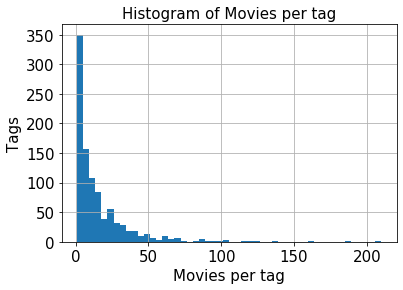

In [15]:
print(tags_scores_high_dum.filter(regex=("tid_*")).aggregate(np.sum).max())
hists = tags_scores_high_dum.filter(regex=("tid_*")).aggregate(np.sum).hist(bins=50, xlabelsize=15, ylabelsize=15)
hists.set_ylabel("Tags", size=15)
hists.set_xlabel("Movies per tag", size=15)
hists.set_title("Histogram of Movies per tag", size=15);
# y-axis: number of tags 
# x-axis: movies per tag

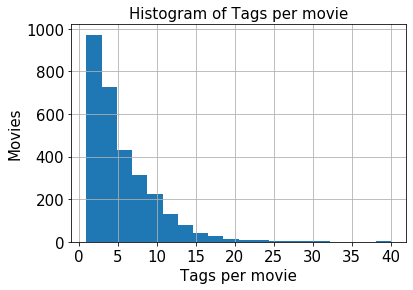

In [16]:
hists = tags_scores_high.groupby("mid").count().hist(bins=20, column="tid", xlabelsize=15, ylabelsize=15)
hists[0][0].set_ylabel("Movies", size=15)
hists[0][0].set_xlabel("Tags per movie", size=15)
hists[0][0].set_title("Histogram of Tags per movie", size=15);
# y-axis: number of movies 
# x-axis: tags per movie

### Cluster tags

In [17]:
n_clusters=100
method = 'KMeans'

# setup data structures
tags_per_movie = tags_scores_high_dum.groupby("mid").sum()

movie_tags_cluster = pd.merge(movies_pd, tags_per_movie, how='inner', on='mid')
x_data = tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int)


# launch clustering
if method == 'AgglomerativeClustering':
    aggClus = cluster.AgglomerativeClustering(n_clusters=n_clusters, affinity='l2', linkage='average')
    tags_cluster = aggClus.fit_predict(tags_per_movie.filter(regex="(tid_*)").to_numpy(dtype=np.int))

elif method == 'KMeans':
    kmeansClus = cluster.KMeans(n_clusters=n_clusters, precompute_distances='auto')
    tags_cluster = kmeansClus.fit_predict(x_data)

elif method == 'AffinityPropagation':
    apClus = cluster.AffinityPropagation()
    tags_cluster = apClus.fit_predict(x_data)
    # AP automatically determines the number of clusters
    n_clusters = np.unique(tags_cluster).size
    print(n_clusters)

else:
    print('unkown option', method)

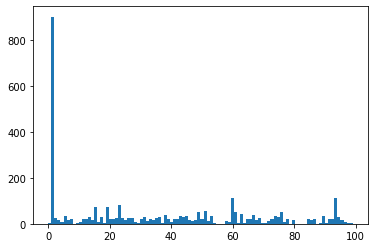

In [18]:
# Histogram of Movies per cluster
pyplot.hist(tags_cluster, bins=n_clusters);

In [19]:
print(tags_cluster[:10])
for i in range(n_clusters):
    idx = np.where(tags_cluster == i)[0]
    print('\nCluster', i, '(number of movies: {idx.size})')
    idx2 = tags_per_movie.iloc[idx].index
    #print(movie_tags_cluster[movie_tags_cluster.mid.isin(idx2)][['mName', 'mGenres']].to_string(index=False))
    display(movie_tags_cluster[movie_tags_cluster.mid.isin(idx2)][['mName', 'mGenres']])

[53 85 76  1 76 45 15 61 19  3]

Cluster 0 (number of movies: 4)


,mName,mGenres
95,Braveheart (1995),Action|Drama|War
960,Gandhi (1982),Drama
1415,"Last Emperor, The (1987)",Drama|War
2700,Gladiator (2000),Action|Drama



Cluster 1 (number of movies: 902)


,mName,mGenres
3,Waiting to Exhale (1995),Comedy|Drama
17,Four Rooms (1995),Thriller
20,Get Shorty (1995),Action|Comedy|Drama
23,Powder (1995),Drama|Sci-Fi
24,Leaving Las Vegas (1995),Drama|Romance
25,Othello (1995),Drama
30,Dangerous Minds (1995),Drama
32,Wings of Courage (1995),Adventure|Romance
36,Across the Sea of Time (1995),Documentary
40,Richard III (1995),Drama|War



Cluster 2 (number of movies: 24)


,mName,mGenres
47,Pocahontas (1995),Animation|Children's|Musical|Romance
295,"Lion King, The (1994)",Animation|Children's|Musical
467,Aladdin (1992),Animation|Children's|Comedy|Musical
472,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
473,Beauty and the Beast (1991),Animation|Children's|Musical
474,Pinocchio (1940),Animation|Children's
487,"Aristocats, The (1970)",Animation|Children's
745,Cinderella (1950),Animation|Children's|Musical
748,"Sword in the Stone, The (1963)",Animation|Children's
752,Dumbo (1941),Animation|Children's|Musical



Cluster 3 (number of movies: 15)


,mName,mGenres
9,GoldenEye (1995),Action|Adventure|Thriller
1256,Tomorrow Never Dies (1997),Action|Romance|Thriller
1766,"View to a Kill, A (1985)",Action
2234,Goldfinger (1964),Action
2235,From Russia with Love (1963),Action
2236,Dr. No (1962),Action
2267,For Your Eyes Only (1981),Action
2268,Licence to Kill (1989),Action
2269,Live and Let Die (1973),Action
2271,Thunderball (1965),Action



Cluster 4 (number of movies: 10)


,mName,mGenres
46,Seven (Se7en) (1995),Crime|Thriller
657,"Maltese Falcon, The (1941)",Film-Noir|Mystery
685,Laura (1944),Crime|Film-Noir|Mystery
693,"Thin Man, The (1934)",Mystery
784,Crossfire (1947),Crime|Film-Noir
785,"Murder, My Sweet (1944)",Film-Noir|Thriller
951,"Big Sleep, The (1946)",Film-Noir|Mystery
1354,Insomnia (1997),Thriller
1405,In the Heat of the Night (1967),Drama|Mystery
2589,Double Indemnity (1944),Crime|Film-Noir



Cluster 5 (number of movies: 36)


,mName,mGenres
56,"Indian in the Cupboard, The (1995)",Adventure|Children's|Fantasy
223,Mary Shelley's Frankenstein (1994),Drama|Horror
357,Even Cowgirls Get the Blues (1993),Comedy|Romance
486,Jane Eyre (1996),Drama|Romance
503,Moll Flanders (1996),Drama
508,James and the Giant Peach (1996),Animation|Children's|Musical
548,Cold Comfort Farm (1995),Comedy
692,East of Eden (1955),Drama
729,"Chamber, The (1996)",Drama
925,"Shining, The (1980)",Horror



Cluster 6 (number of movies: 17)


,mName,mGenres
190,French Kiss (1995),Comedy|Romance
203,I.Q. (1994),Comedy|Romance
275,While You Were Sleeping (1995),Comedy|Romance
432,Sleepless in Seattle (1993),Comedy|Romance
475,Pretty Woman (1990),Comedy|Romance
534,"Truth About Cats & Dogs, The (1996)",Comedy|Romance
973,When Harry Met Sally... (1989),Comedy|Romance
1010,"Mirror Has Two Faces, The (1996)",Comedy|Romance
1081,Fools Rush In (1997),Comedy|Romance
1153,My Best Friend's Wedding (1997),Comedy|Romance



Cluster 7 (number of movies: 20)


,mName,mGenres
666,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
847,Cinema Paradiso (1988),Comedy|Drama|Romance
852,Paths of Glory (1957),Drama|War
881,"Third Man, The (1949)",Mystery|Thriller
905,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama
915,Touch of Evil (1958),Crime|Film-Noir|Thriller
918,8 1/2 (1963),Drama
927,M (1931),Crime|Film-Noir|Thriller
1712,"Elephant Man, The (1980)",Drama
1744,Nights of Cabiria (Le Notti di Cabiria) (1957),Drama



Cluster 8 (number of movies: 1)


,mName,mGenres
289,Forrest Gump (1994),Comedy|Romance|War



Cluster 9 (number of movies: 3)


,mName,mGenres
1586,Pretty in Pink (1986),Comedy|Drama|Romance
1665,Say Anything... (1989),Comedy|Drama|Romance
2955,Crime and Punishment in Suburbia (2000),Comedy|Drama



Cluster 10 (number of movies: 7)


,mName,mGenres
70,Screamers (1995),Sci-Fi|Thriller
1483,"Black Hole, The (1979)",Sci-Fi
1832,Virus (1999),Horror|Sci-Fi
1896,Westworld (1973),Action|Sci-Fi|Thriller|Western
2152,Saturn 3 (1979),Adventure|Sci-Fi|Thriller
2398,Bicentennial Man (1999),Comedy|Drama|Sci-Fi
2982,Runaway (1984),Sci-Fi|Thriller



Cluster 11 (number of movies: 19)


,mName,mGenres
11,Dracula: Dead and Loving It (1995),Comedy|Horror
301,Naked Gun 33 1/3: The Final Insult (1994),Comedy
358,Fatal Instinct (1993),Comedy
375,Hot Shots! Part Deux (1993),Action|Comedy|War
416,Robin Hood: Men in Tights (1993),Comedy
558,Spy Hard (1996),Comedy
605,High School High (1996),Comedy
945,Young Frankenstein (1974),Comedy|Horror
1478,Mafia! (1998),Comedy|Crime
1554,Dead Men Don't Wear Plaid (1982),Comedy|Crime|Thriller



Cluster 12 (number of movies: 19)


,mName,mGenres
59,Don't Be a Menace to South Central While Drink...,Comedy
91,Happy Gilmore (1996),Comedy
173,Billy Madison (1995),Comedy
185,Dumb & Dumber (1994),Comedy
271,Tommy Boy (1995),Comedy
278,Ace Ventura: Pet Detective (1994),Comedy
865,Up in Smoke (1978),Comedy
1067,Beverly Hills Ninja (1997),Action|Comedy
1274,Half Baked (1998),Comedy
1506,BASEketball (1998),Comedy



Cluster 13 (number of movies: 29)


,mName,mGenres
989,April Fool's Day (1986),Comedy|Horror
999,Candyman (1992),Horror
1053,Scream (1996),Horror|Thriller
1204,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller
1428,Freddy's Dead: The Final Nightmare (1991),Horror
1439,Halloween III: Season of the Witch (1983),Horror
1442,Prom Night (1980),Horror
1443,Hello Mary Lou: Prom Night II (1987),Horror
1444,Prom Night III: The Last Kiss (1989),Horror
1445,Prom Night IV: Deliver Us From Evil (1992),Horror



Cluster 14 (number of movies: 15)


,mName,mGenres
202,"Hunted, The (1995)",Action
319,Street Fighter (1994),Action
402,"Next Karate Kid, The (1994)",Action|Children's
511,Bloodsport 2 (1995),Action
530,"Quest, The (1996)",Action|Adventure
712,In the Line of Duty 2 (1987),Action
718,Maximum Risk (1996),Action|Adventure|Thriller
845,Best of the Best 3: No Turning Back (1995),Action
1235,Mortal Kombat: Annihilation (1997),Action|Adventure
1374,Lethal Weapon 4 (1998),Action|Comedy|Crime|Drama



Cluster 15 (number of movies: 73)


,mName,mGenres
6,Sabrina (1995),Comedy|Romance
10,"American President, The (1995)",Comedy|Drama|Romance
68,Bed of Roses (1996),Drama|Romance
92,"Bridges of Madison County, The (1995)",Drama|Romance
101,If Lucy Fell (1996),Comedy|Romance
112,Up Close and Personal (1996),Drama|Romance
166,"Walk in the Clouds, A (1995)",Drama|Romance
172,Before Sunrise (1995),Drama|Romance
179,Don Juan DeMarco (1995),Comedy|Drama|Romance
191,Forget Paris (1995),Comedy|Romance



Cluster 16 (number of movies: 9)


,mName,mGenres
35,Dead Man Walking (1995),Drama
493,Primal Fear (1996),Drama|Thriller
837,He Walked by Night (1948),Crime|Film-Noir|Thriller
861,"Thin Blue Line, The (1988)",Documentary
1018,Paradise Lost: The Child Murders at Robin Hood...,Documentary
1165,Cop Land (1997),Crime|Drama|Mystery
1186,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
1228,Witness (1985),Drama|Romance|Thriller
2959,Under Suspicion (2000),Crime



Cluster 17 (number of movies: 29)


,mName,mGenres
113,"Birdcage, The (1996)",Comedy
138,Jeffrey (1995),Comedy
260,Strawberry and Chocolate (Fresa y chocolate) (...,Drama
279,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama
316,Boys Life (1995),Drama
371,Go Fish (1994),Drama|Romance
461,"Celluloid Closet, The (1995)",Documentary
603,Stonewall (1995),Drama
622,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)",Comedy
765,Beautiful Thing (1996),Drama|Romance



Cluster 18 (number of movies: 2)


,mName,mGenres
870,Aliens (1986),Action|Sci-Fi|Thriller|War
883,Alien (1979),Action|Horror|Sci-Fi|Thriller



Cluster 19 (number of movies: 73)


,mName,mGenres
8,Sudden Death (1995),Action
14,Cutthroat Island (1995),Action|Adventure|Romance
19,Money Train (1995),Action
22,Assassins (1995),Thriller
85,Broken Arrow (1996),Action|Thriller
115,Bad Boys (1995),Action
131,Desperado (1995),Action|Romance|Thriller
133,Die Hard: With a Vengeance (1995),Action|Thriller
164,Under Siege 2: Dark Territory (1995),Action
181,Drop Zone (1994),Action



Cluster 20 (number of movies: 19)


,mName,mGenres
107,Jade (1995),Thriller
156,Showgirls (1995),Drama
281,Bitter Moon (1992),Drama
350,Color of Night (1994),Drama|Thriller
396,In the Realm of the Senses (Ai no corrida) (1976),Drama
430,Sirens (1994),Comedy|Drama
449,"Paris, France (1993)",Comedy
526,Delta of Venus (1994),Drama
859,"Sex, Lies, and Videotape (1989)",Drama
1095,Kama Sutra: A Tale of Love (1996),Romance



Cluster 21 (number of movies: 22)


,mName,mGenres
121,Batman Forever (1995),Action|Adventure|Comedy|Crime
140,Judge Dredd (1995),Action|Adventure|Sci-Fi
426,"Shadow, The (1994)",Action
470,Batman (1989),Action|Adventure|Crime|Drama
569,"Phantom, The (1996)",Adventure
1030,Batman Returns (1992),Action|Adventure|Comedy|Crime
1149,Batman & Robin (1997),Action|Adventure|Crime
1167,Spawn (1997),Action|Adventure|Sci-Fi|Thriller
1173,Steel (1997),Action
1489,Condorman (1981),Action|Adventure|Children's|Comedy



Cluster 22 (number of movies: 24)


,mName,mGenres
42,Restoration (1995),Drama
177,Circle of Friends (1995),Drama|Romance
253,"Secret of Roan Inish, The (1994)",Drama
338,Blown Away (1994),Action|Thriller
363,Widows' Peak (1994),Drama
518,"Run of the Country, The (1995)",Drama
571,"Last of the High Kings, The (a.k.a. Summer Fli...",Drama
719,Michael Collins (1996),Drama|War
854,Hear My Song (1991),Comedy
895,"Quiet Man, The (1952)",Comedy|Romance



Cluster 23 (number of movies: 80)


,mName,mGenres
87,"Hate (Haine, La) (1995)",Drama
171,Before the Rain (Pred dozhdot) (1994),Drama
247,Three Colors: Red (1994),Drama
248,Three Colors: Blue (1993),Drama
249,Three Colors: White (1994),Drama
387,King of the Hill (1993),Drama
428,Short Cuts (1993),Drama
507,Purple Noon (1960),Crime|Thriller
512,Pather Panchali (1955),Drama
513,"World of Apu, The (Apur Sansar) (1959)",Drama



Cluster 24 (number of movies: 25)


,mName,mGenres
258,Shallow Grave (1994),Thriller
304,Red Rock West (1992),Thriller
391,Malice (1993),Thriller
417,Romeo Is Bleeding (1993),Crime|Thriller
853,"Grifters, The (1990)",Crime|Drama|Film-Noir
1008,Blood & Wine (1997),Drama
1193,"Game, The (1997)",Mystery|Thriller
1205,"Devil's Advocate, The (1997)",Crime|Horror|Mystery|Thriller
1225,Deceiver (1997),Crime
1275,Fallen (1998),Action|Mystery|Thriller



Cluster 25 (number of movies: 15)


,mName,mGenres
374,Heaven & Earth (1993),Action|Drama|War
800,Platoon (1986),Drama|War
877,Apocalypse Now (1979),Drama|War
891,Full Metal Jacket (1987),Action|Drama|War
930,"Deer Hunter, The (1978)",Drama|War
1382,All Quiet on the Western Front (1930),War
1750,Savior (1998),Drama
1813,"Thin Red Line, The (1998)",Action|Drama|War
2009,Pork Chop Hill (1959),War
2186,Three Kings (1999),Drama|War



Cluster 26 (number of movies: 25)


,mName,mGenres
643,Singin' in the Rain (1952),Musical|Romance
644,"American in Paris, An (1951)",Musical|Romance
645,Funny Face (1957),Comedy|Musical
651,"Gay Divorcee, The (1934)",Comedy|Musical|Romance
679,"Band Wagon, The (1953)",Comedy|Musical
688,Top Hat (1935),Comedy|Musical|Romance
774,Everyone Says I Love You (1996),Comedy|Musical|Romance
782,Shall We Dance? (1937),Comedy|Musical|Romance
783,"Damsel in Distress, A (1937)",Comedy|Musical|Romance
860,Strictly Ballroom (1992),Comedy|Romance



Cluster 27 (number of movies: 25)


,mName,mGenres
64,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller
96,Taxi Driver (1976),Drama|Thriller
233,Natural Born Killers (1994),Action|Thriller
235,Once Were Warriors (1994),Crime|Drama
385,Kalifornia (1993),Drama|Thriller
386,Killing Zoe (1994),Thriller
394,Menace II Society (1993),Action|Crime|Drama
418,Romper Stomper (1992),Action|Drama
446,True Romance (1993),Action|Crime|Romance
477,"Wild Bunch, The (1969)",Western



Cluster 28 (number of movies: 7)


,mName,mGenres
957,Some Kind of Wonderful (1987),Drama|Romance
1423,"Breakfast Club, The (1985)",Comedy|Drama
1575,Weird Science (1985),Comedy
1585,Sixteen Candles (1984),Comedy
2206,Risky Business (1983),Comedy
2209,Ferris Bueller's Day Off (1986),Comedy
2438,Fast Times at Ridgemont High (1982),Comedy



Cluster 29 (number of movies: 4)


,mName,mGenres
38,Clueless (1995),Comedy|Romance
1860,She's All That (1999),Comedy|Romance
1933,10 Things I Hate About You (1999),Comedy|Romance
1940,Never Been Kissed (1999),Comedy|Romance



Cluster 30 (number of movies: 21)


,mName,mGenres
31,Twelve Monkeys (1995),Drama|Sci-Fi
139,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller
160,Strange Days (1995),Action|Crime|Sci-Fi
167,Waterworld (1995),Action|Adventure
309,Timecop (1994),Action|Sci-Fi
434,Blade Runner (1982),Film-Noir|Sci-Fi
759,"Lawnmower Man, The (1992)",Action|Sci-Fi|Thriller
1129,"Fifth Element, The (1997)",Action|Sci-Fi
1211,Gattaca (1997),Drama|Sci-Fi|Thriller
1230,Starship Troopers (1997),Action|Adventure|Sci-Fi|War



Cluster 31 (number of movies: 29)


,mName,mGenres
384,Jurassic Park (1993),Action|Adventure|Sci-Fi
554,Twister (1996),Action|Adventure|Romance|Thriller
587,Daylight (1996),Action|Adventure|Thriller
827,"Howling, The (1980)",Horror
1069,Dante's Peak (1997),Action|Thriller
1111,Anaconda (1997),Action|Adventure|Thriller
1122,Volcano (1997),Drama|Thriller
1140,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
1347,Godzilla (1998),Action|Sci-Fi
1466,"Poseidon Adventure, The (1972)",Action|Adventure



Cluster 32 (number of movies: 12)


,mName,mGenres
208,Just Cause (1995),Mystery|Thriller
593,"Time to Kill, A (1996)",Drama
1145,Trial and Error (1997),Comedy|Romance
1226,"Rainmaker, The (1997)",Drama
1679,"Few Good Men, A (1992)",Crime|Drama
1704,My Cousin Vinny (1992),Comedy
2330,"Verdict, The (1982)",Drama
2358,Jagged Edge (1985),Thriller
2577,...And Justice for All (1979),Drama|Thriller
2617,Inherit the Wind (1960),Drama



Cluster 33 (number of movies: 19)


,mName,mGenres
637,Halloween: The Curse of Michael Myers (1995),Horror|Thriller
1004,"Nightmare on Elm Street, A (1984)",Horror
1424,Nightmare on Elm Street Part 2: Freddy's Reven...,Horror
1425,"Nightmare on Elm Street 3: Dream Warriors, A (...",Horror
1426,"Nightmare on Elm Street 4: The Dream Master, A...",Horror
1427,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror
1429,Friday the 13th (1980),Horror
1430,Friday the 13th Part 2 (1981),Horror
1431,Friday the 13th Part 3: 3D (1982),Horror
1432,Friday the 13th: The Final Chapter (1984),Horror



Cluster 34 (number of movies: 16)


,mName,mGenres
238,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
724,2 Days in the Valley (1996),Crime
815,"Funeral, The (1996)",Drama
916,Nikita (La Femme Nikita) (1990),Thriller
931,Diva (1981),Action|Drama|Mystery|Romance|Thriller
1051,Beavis and Butt-head Do America (1996),Animation|Comedy
1066,Underworld (1997),Thriller
1112,Grosse Pointe Blank (1997),Comedy|Crime
1261,Jackie Brown (1997),Crime|Drama
1309,Homegrown (1998),Comedy|Thriller



Cluster 35 (number of movies: 24)


,mName,mGenres
162,Three Wishes (1995),Drama
192,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children's
195,Fluke (1995),Children's|Drama
388,Lassie (1994),Adventure|Children's
460,Andre (1994),Adventure|Children's
483,Homeward Bound II: Lost in San Francisco (1996),Adventure|Children's
735,Old Yeller (1957),Children's|Drama
738,Homeward Bound: The Incredible Journey (1993),Adventure|Children's
739,"Shaggy Dog, The (1959)",Children's|Comedy
1021,101 Dalmatians (1996),Children's|Comedy



Cluster 36 (number of movies: 28)


,mName,mGenres
163,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy
229,Nobody's Fool (1994),Drama
273,What's Eating Gilbert Grape (1993),Drama
565,Gold Diggers: The Secret of Bear Mountain (1995),Adventure|Children's
589,Lone Star (1996),Drama|Mystery
614,"Spitfire Grill, The (1996)",Drama
713,Picnic (1955),Drama
737,Pollyanna (1960),Children's|Comedy|Drama
906,Local Hero (1983),Comedy
1076,Waiting for Guffman (1996),Comedy



Cluster 37 (number of movies: 2)


,mName,mGenres
868,Raiders of the Lost Ark (1981),Action|Adventure
958,Indiana Jones and the Last Crusade (1989),Action|Adventure



Cluster 38 (number of movies: 39)


,mName,mGenres
267,Star Trek: Generations (1994),Action|Adventure|Sci-Fi
636,Land Before Time III: The Time of the Great Gi...,Animation|Children's
942,Highlander (1986),Action|Adventure
979,Alien� (1992),Action|Horror|Sci-Fi|Thriller
981,Amityville 1992: It's About Time (1992),Horror
982,Amityville 3-D (1983),Horror
983,Amityville: Dollhouse (1996),Horror
984,Amityville: A New Generation (1993),Horror
987,"Amityville Curse, The (1990)",Horror
1025,Star Trek VI: The Undiscovered Country (1991),Action|Adventure|Sci-Fi



Cluster 39 (number of movies: 21)


,mName,mGenres
200,Immortal Beloved (1994),Drama|Romance
383,What's Love Got to Do with It? (1993),Drama
441,Thirty-Two Short Films About Glenn Gould (1993),Documentary
617,Basquiat (1996),Drama
803,"Doors, The (1991)",Drama|Musical
818,"People vs. Larry Flynt, The (1996)",Drama
894,Amadeus (1984),Drama
1014,Shine (1996),Drama|Romance
1072,Prefontaine (1997),Drama
1096,Private Parts (1997),Comedy|Drama



Cluster 40 (number of movies: 8)


,mName,mGenres
422,Schindler's List (1993),Drama|War
909,Glory (1989),Action|Drama|War
917,"Bridge on the River Kwai, The (1957)",Drama|War
939,Patton (1970),Drama|War
1479,Saving Private Ryan (1998),Action|Drama|War
2325,"Longest Day, The (1962)",Action|Drama|War
2328,Tora! Tora! Tora! (1970),War
2834,"Patriot, The (2000)",Action|Drama|War



Cluster 41 (number of movies: 22)


,mName,mGenres
13,Nixon (1995),Drama
88,City Hall (1996),Drama|Thriller
353,Dave (1993),Comedy|Romance
447,"War Room, The (1993)",Documentary
697,Mr. Smith Goes to Washington (1939),Drama
793,"Candidate, The (1972)",Drama
820,"Perfect Candidate, A (1996)",Documentary
846,Bob Roberts (1992),Comedy
934,"Manchurian Candidate, The (1962)",Film-Noir|Thriller
1040,My Fellow Americans (1996),Comedy



Cluster 42 (number of movies: 21)


,mName,mGenres
568,Stalingrad (1993),War
656,Casablanca (1942),Drama|Romance|War
901,"Boat, The (Das Boot) (1981)",Action|Drama|War
1116,Paradise Road (1997),Drama|War
1391,Mrs. Miniver (1942),Drama|War
1821,Tea with Mussolini (1999),Comedy
2010,"Run Silent, Run Deep (1958)",War
2232,"Dirty Dozen, The (1967)",Action|War
2304,Mister Roberts (1955),Comedy|Drama|War
2384,"Sea Wolves, The (1980)",Action|War



Cluster 43 (number of movies: 32)


,mName,mGenres
58,Mr. Holland's Opus (1995),Drama
280,Backbeat (1993),Drama|Musical
478,"Great Day in Harlem, A (1994)",Documentary
626,Kansas City (1996),Crime
762,That Thing You Do! (1996),Comedy
889,"Blues Brothers, The (1980)",Action|Comedy|Musical
955,This Is Spinal Tap (1984),Comedy|Drama|Musical
964,Pink Floyd - The Wall (1982),Drama|Musical|War
974,Hype! (1996),Documentary
1104,Selena (1997),Drama|Musical



Cluster 44 (number of movies: 28)


,mName,mGenres
642,"Philadelphia Story, The (1940)",Comedy|Romance
648,Rear Window (1954),Mystery|Thriller
652,North by Northwest (1959),Drama|Thriller
654,Some Like It Hot (1959),Comedy|Crime
660,Roman Holiday (1953),Comedy|Romance
663,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
667,Citizen Kane (1941),Drama
672,Rebecca (1940),Romance|Thriller
683,"Adventures of Robin Hood, The (1938)",Action|Adventure
696,It's a Wonderful Life (1946),Drama



Cluster 45 (number of movies: 36)


,mName,mGenres
5,Heat (1995),Action|Crime|Thriller
169,Wild Bill (1995),Western
244,"Quick and the Dead, The (1995)",Action|Adventure|Western
313,Wyatt Earp (1994),Western
332,Bad Girls (1994),Western
445,Tombstone (1993),Western
538,Dead Man (1995),Western
703,Angel and the Badman (1947),Western
706,"Outlaw, The (1943)",Western
855,"Shooter, The (1995)",Action



Cluster 46 (number of movies: 17)


,mName,mGenres
141,Kids (1995),Drama
341,Boxing Helena (1993),Mystery|Romance|Thriller
715,Bliss (1997),Drama|Romance
848,"Cook the Thief His Wife & Her Lover, The (1989)",Drama
1113,Kissed (1996),Romance
1227,Boogie Nights (1997),Drama
1345,Lawn Dogs (1997),Drama
1656,Let's Talk About Sex (1998),Drama
1775,Jerry Springer: Ringmaster (1998),Drama
1876,8MM (1999),Thriller



Cluster 47 (number of movies: 13)


,mName,mGenres
144,Love & Human Remains (1993),Comedy
240,Priest (1994),Drama
262,"Sum of Us, The (1994)",Comedy
405,Philadelphia (1993),Drama
442,Threesome (1994),Comedy|Romance
1115,Hollow Reed (1996),Drama
1182,"Kiss Me, Guido (1997)",Comedy
1350,"Opposite of Sex, The (1998)",Comedy|Drama
1728,Gods and Monsters (1998),Drama
2187,"Happy, Texas (1999)",Comedy



Cluster 48 (number of movies: 16)


,mName,mGenres
15,Casino (1995),Drama|Thriller
74,Things to Do in Denver when You're Dead (1995),Crime|Drama|Romance
342,"Bronx Tale, A (1993)",Drama
345,Carlito's Way (1993),Crime|Drama
624,Bound (1996),Crime|Drama|Romance|Thriller
882,GoodFellas (1990),Crime|Drama
896,Once Upon a Time in America (1984),Crime|Drama|Thriller
912,Miller's Crossing (1990),Drama
1089,Donnie Brasco (1997),Crime|Drama
1174,Hoodlum (1997),Crime|Drama|Film-Noir



Cluster 49 (number of movies: 51)


,mName,mGenres
469,Dances with Wolves (1990),Adventure|Drama|Western
482,Fargo (1996),Crime|Drama|Thriller
649,It Happened One Night (1934),Comedy
653,"Apartment, The (1960)",Comedy|Drama
658,My Fair Lady (1964),Musical|Romance
664,Gone with the Wind (1939),Drama|Romance|War
670,All About Eve (1950),Drama
691,Giant (1956),Drama
695,Around the World in 80 Days (1956),Adventure|Comedy
757,"Sound of Music, The (1965)",Musical



Cluster 50 (number of movies: 20)


,mName,mGenres
270,Village of the Damned (1995),Horror|Sci-Fi
340,Body Snatchers (1993),Horror|Sci-Fi|Thriller
370,"Getaway, The (1994)",Action
499,Diabolique (1996),Drama|Thriller
721,Last Man Standing (1996),Action|Drama|Western
1000,Cape Fear (1991),Thriller
1003,Cat People (1982),Horror
1084,That Darn Cat! (1997),Children's|Comedy|Mystery
1240,"Jackal, The (1997)",Action|Thriller
1356,"Perfect Murder, A (1998)",Mystery|Thriller



Cluster 51 (number of movies: 56)


,mName,mGenres
158,Species (1995),Horror|Sci-Fi
255,Stargate (1994),Action|Adventure|Sci-Fi
408,Robert A. Heinlein's The Puppet Masters (1994),Horror|Sci-Fi
516,Barbarella (1968),Adventure|Sci-Fi
562,"Arrival, The (1996)",Action|Sci-Fi|Thriller
576,Independence Day (ID4) (1996),Action|Sci-Fi|War
824,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
920,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi
967,Forbidden Planet (1956),Sci-Fi
1013,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi



Cluster 52 (number of movies: 11)


,mName,mGenres
376,Live Nude Girls (1995),Comedy
414,"Road to Wellville, The (1994)",Comedy
577,Stealing Beauty (1996),Drama
770,Normal Life (1996),Crime|Drama
1281,B. Monkey (1998),Romance|Thriller
1290,Twilight (1998),Crime|Drama
1306,Two Girls and a Guy (1997),Comedy|Drama
2259,Body Shots (1999),Drama
2266,Melvin and Howard (1980),Drama
2512,Reindeer Games (2000),Action|Thriller



Cluster 53 (number of movies: 33)


,mName,mGenres
0,Toy Story (1995),Animation|Children's|Comedy
193,"Goofy Movie, A (1995)",Animation|Children's|Comedy|Romance
252,"Swan Princess, The (1994)",Animation|Children's
515,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy
746,Winnie the Pooh and the Blustery Day (1968),Animation|Children's
747,"Three Caballeros, The (1945)",Animation|Children's|Musical
749,So Dear to My Heart (1949),Children's|Drama
753,Pete's Dragon (1977),Adventure|Animation|Children's|Musical
949,Fantasia (1940),Animation|Children's|Musical
1151,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical



Cluster 54 (number of movies: 5)


,mName,mGenres
559,"Close Shave, A (1995)",Animation|Comedy|Thriller
833,"Wrong Trousers, The (1993)",Animation|Comedy
892,"Grand Day Out, A (1992)",Animation|Comedy
2583,Creature Comforts (1990),Animation|Comedy
2832,Chicken Run (2000),Animation|Children's|Comedy



Cluster 55 (number of movies: 1)


,mName,mGenres
873,12 Angry Men (1957),Drama



Cluster 56 (number of movies: 1)


,mName,mGenres
471,"Silence of the Lambs, The (1991)",Drama|Thriller



Cluster 57 (number of movies: 1)


,mName,mGenres
2644,Network (1976),Comedy|Drama



Cluster 58 (number of movies: 13)


,mName,mGenres
28,"City of Lost Children, The (1995)",Adventure|Sci-Fi
556,Ghost in the Shell (Kokaku kidotai) (1995),Animation|Sci-Fi
668,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
850,Delicatessen (1991),Comedy|Sci-Fi
869,Brazil (1985),Sci-Fi
941,Akira (1988),Adventure|Animation|Sci-Fi|Thriller
1147,"Pillow Book, The (1995)",Drama|Romance
1272,Dark City (1998),Film-Noir|Sci-Fi|Thriller
1377,Pi (1998),Sci-Fi|Thriller
1700,What Dreams May Come (1998),Drama|Romance



Cluster 59 (number of movies: 7)


,mName,mGenres
236,Poison Ivy II (1995),Thriller
433,Sliver (1993),Thriller
802,Basic Instinct (1992),Mystery|Thriller
862,Tie Me Up! Tie Me Down! (1990),Drama
1299,Wild Things (1998),Crime|Drama|Mystery|Thriller
2327,Poison Ivy: New Seduction (1997),Thriller
2699,Two Moon Juction (1988),Drama



Cluster 60 (number of movies: 114)


,mName,mGenres
60,Bio-Dome (1996),Comedy
63,Friday (1995),Comedy
80,Black Sheep (1996),Comedy
83,Vampire in Brooklyn (1995),Comedy|Romance
108,Down Periscope (1996),Comedy
145,Mallrats (1995),Comedy
150,Nine Months (1995),Comedy
178,Clerks (1994),Comedy
206,"Jerky Boys, The (1994)",Comedy
207,Junior (1994),Comedy|Sci-Fi



Cluster 61 (number of movies: 52)


,mName,mGenres
7,Tom and Huck (1995),Adventure|Children's
39,"Cry, the Beloved Country (1995)",Drama
111,"Neon Bible, The (1995)",Drama
128,Congo (1995),Action|Adventure|Mystery|Sci-Fi
132,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller
154,"Scarlet Letter, The (1995)",Drama
180,Disclosure (1994),Drama|Thriller
188,Exit to Eden (1994),Comedy
194,Hideaway (1995),Thriller
212,"Little Princess, A (1995)",Children's|Drama



Cluster 62 (number of movies: 3)


,mName,mGenres
49,"Usual Suspects, The (1995)",Crime|Thriller
1938,Following (1998),Drama
2242,Fight Club (1999),Drama



Cluster 63 (number of movies: 42)


,mName,mGenres
34,Carrington (1995),Drama|Romance
84,Beautiful Girls (1996),Drama
114,"Brothers McMullen, The (1995)",Comedy
147,Moonlight and Valentino (1995),Drama|Romance
174,Boys on the Side (1995),Comedy|Drama
186,Eat Drink Man Woman (1994),Comedy|Drama
490,My Favorite Season (1993),Drama
522,It's My Party (1995),Drama
591,Walking and Talking (1996),Romance
592,She's the One (1996),Comedy|Romance



Cluster 64 (number of movies: 5)


,mName,mGenres
886,Ran (1985),Drama|War
1470,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
2200,Sanjuro (1962),Action|Adventure
2299,Yojimbo (1961),Comedy|Drama|Western
2347,Kagemusha (1980),Drama|War



Cluster 65 (number of movies: 19)


,mName,mGenres
149,"Net, The (1995)",Sci-Fi|Thriller
224,Man of the House (1995),Comedy
351,Cops and Robbersons (1994),Comedy
436,Striking Distance (1993),Action
607,Chain Reaction (1996),Action|Adventure|Thriller
677,To Catch a Thief (1955),Comedy|Romance|Thriller
772,Shadow Conspiracy (1997),Thriller
1062,Murder at 1600 (1997),Mystery|Thriller
1085,Vegas Vacation (1997),Comedy
1639,Saboteur (1942),Thriller



Cluster 66 (number of movies: 20)


,mName,mGenres
26,Now and Then (1995),Drama
37,It Takes Two (1995),Comedy
602,"First Wives Club, The (1996)",Comedy
671,"Women, The (1939)",Comedy
1162,G.I. Jane (1997),Action|Drama|War
1232,"Joy Luck Club, The (1993)",Drama
1259,"Horse Whisperer, The (1998)",Drama
1353,Hope Floats (1998),Comedy|Drama|Romance
1663,Working Girl (1988),Comedy|Drama
1715,Practical Magic (1998),Drama|Romance



Cluster 67 (number of movies: 39)


,mName,mGenres
51,"Big Green, The (1995)",Children's|Comedy
198,Hoop Dreams (1994),Documentary
287,Cobb (1994),Drama
325,Above the Rim (1994),Drama
330,"Air Up There, The (1994)",Comedy
339,Blue Chips (1994),Drama
407,"Program, The (1993)",Action|Drama
423,"Scout, The (1994)",Drama
456,Little Big League (1994),Children's|Comedy
505,Eddie (1996),Comedy



Cluster 68 (number of movies: 17)


,mName,mGenres
146,Mighty Morphin Power Rangers: The Movie (1995),Action|Children's
334,"Beverly Hillbillies, The (1993)",Comedy
464,"Brady Bunch Movie, The (1995)",Comedy
497,Sgt. Bilko (1996),Comedy
1073,McHale's Navy (1997),Comedy|War
1107,Turbo: A Power Rangers Movie (1997),Action|Adventure|Children's
1175,Leave It to Beaver (1997),Comedy
1568,"Addams Family, The (1991)",Comedy
1593,"Avengers, The (1998)",Action|Adventure
1870,My Favorite Martian (1999),Comedy|Sci-Fi



Cluster 69 (number of movies: 25)


,mName,mGenres
344,Calendar Girl (1993),Drama
1033,Grease (1978),Comedy|Musical|Romance
1120,Romy and Michele's High School Reunion (1997),Comedy
1574,Adventures in Babysitting (1987),Adventure|Comedy
1587,St. Elmo's Fire (1985),Drama|Romance
1610,"Strike! (a.k.a. All I Wanna Do, The Hairy Bird...",Comedy
1671,No Small Affair (1984),Comedy|Romance
1814,"Faculty, The (1998)",Horror|Sci-Fi
1831,Varsity Blues (1999),Comedy|Drama
1879,Eight Days a Week (1997),Comedy



Cluster 70 (number of movies: 3)


,mName,mGenres
937,Back to the Future (1985),Comedy|Sci-Fi
1464,Back to the Future Part II (1989),Comedy|Sci-Fi
1465,Back to the Future Part III (1990),Comedy|Sci-Fi|Western



Cluster 71 (number of movies: 2)


,mName,mGenres
239,Pulp Fiction (1994),Crime|Drama
799,Reservoir Dogs (1992),Crime|Thriller



Cluster 72 (number of movies: 12)


,mName,mGenres
116,"Basketball Diaries, The (1995)",Drama
574,Trainspotting (1996),Drama
633,Sweet Nothing (1995),Drama
1075,Gridlock'd (1997),Crime
1349,Fear and Loathing in Las Vegas (1998),Comedy|Drama
1680,Permanent Midnight (1998),Drama
1741,Sid and Nancy (1986),Drama
2290,Drugstore Cowboy (1989),Crime|Drama
2484,Bad Lieutenant (1992),Crime|Drama
2771,"Man with the Golden Arm, The (1955)",Drama



Cluster 73 (number of movies: 19)


,mName,mGenres
354,Dazed and Confused (1993),Comedy
527,Angus (1995),Comedy
545,"Craft, The (1996)",Drama|Horror
811,Rebel Without a Cause (1955),Drama
924,Better Off Dead... (1985),Comedy
935,Pump Up the Volume (1990),Drama
952,Heathers (1989),Comedy
1359,Can't Hardly Wait (1998),Comedy|Drama|Romance
1477,Disturbing Behavior (1998),Horror|Thriller
1660,My Bodyguard (1980),Drama



Cluster 74 (number of movies: 34)


,mName,mGenres
21,Copycat (1995),Crime|Drama|Thriller
81,Nick of Time (1995),Action|Thriller
129,Crimson Tide (1995),Drama|Thriller|War
148,Mute Witness (1994),Thriller
337,Blink (1994),Thriller
368,"Fugitive, The (1993)",Action|Thriller
381,In the Line of Fire (1993),Action|Thriller
604,Ransom (1996),Drama|Thriller
650,Gaslight (1944),Mystery|Thriller
797,Dial M for Murder (1954),Mystery|Thriller



Cluster 75 (number of movies: 29)


,mName,mGenres
29,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
55,"Postino, Il (The Postman) (1994)",Drama|Romance
216,Legends of the Fall (1994),Drama|Romance|War|Western
539,"Horseman on the Roof, The (Hussard sur le toit...",Drama
813,Microcosmos (Microcosmos: Le peuple de l'herbe...,Documentary
851,"Double Life of Veronique, The (La Double Vie d...",Drama
856,"English Patient, The (1996)",Drama|Romance|War
900,Stalker (1979),Mystery|Sci-Fi
947,Raise the Red Lantern (1991),Drama
956,Koyaanisqatsi (1983),Documentary|War



Cluster 76 (number of movies: 52)


,mName,mGenres
2,Grumpier Old Men (1995),Comedy|Romance
4,Father of the Bride Part II (1995),Comedy
322,Highlander III: The Sorcerer (1994),Action|Sci-Fi
326,Addams Family Values (1993),Comedy
346,City Slickers II: The Legend of Curly's Gold (...,Comedy|Western
415,Robocop 3 (1993),Sci-Fi|Thriller
481,Candyman: Farewell to the Flesh (1995),Horror
494,All Dogs Go to Heaven 2 (1996),Animation|Children's|Musical
598,"Very Brady Sequel, A (1996)",Comedy
610,"Crow: City of Angels, The (1996)",Action|Thriller



Cluster 77 (number of movies: 10)


,mName,mGenres
18,Ace Ventura: When Nature Calls (1995),Comedy
581,Kingpin (1996),Comedy
791,Monty Python's Life of Brian (1979),Comedy
831,Monty Python and the Holy Grail (1974),Comedy
1123,Austin Powers: International Man of Mystery (1...,Comedy
1379,There's Something About Mary (1998),Comedy
1699,"Night at the Roxbury, A (1998)",Comedy
2021,Austin Powers: The Spy Who Shagged Me (1999),Comedy
2833,"Me, Myself and Irene (2000)",Comedy
2862,Scary Movie (2000),Comedy|Horror



Cluster 78 (number of movies: 20)


,mName,mGenres
99,Anne Frank Remembered (1995),Documentary
294,"Wonderful, Horrible Life of Leni Riefenstahl, ...",Documentary
639,Mother Night (1996),Drama
669,Golden Earrings (1947),Adventure|Romance
689,To Be or Not to Be (1942),Comedy|Drama|War
840,"Tin Drum, The (Blechtrommel, Die) (1979)",Drama
948,"Great Dictator, The (1940)",Comedy
1520,Mephisto (1981),Drama|War
1550,Swing Kids (1993),Drama|War
1717,Apt Pupil (1998),Drama|Thriller



Cluster 79 (number of movies: 1)


,mName,mGenres
257,"Shawshank Redemption, The (1994)",Drama



Cluster 80 (number of movies: 16)


,mName,mGenres
504,Dragonheart (1996),Action|Adventure|Fantasy
867,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
1163,Conan the Barbarian (1982),Action|Adventure
1422,Labyrinth (1986),Adventure|Children's|Fantasy
1581,"Dark Crystal, The (1982)",Children's|Fantasy|Sci-Fi
1584,Legend (1985),Adventure|Fantasy|Romance
1599,"NeverEnding Story, The (1984)",Adventure|Children's|Fantasy
1600,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children's|Fantasy
1629,Willow (1988),Action|Adventure|Fantasy
2065,"Golden Child, The (1986)",Action|Adventure|Comedy



Cluster 81 (number of movies: 1)


,mName,mGenres
1910,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller



Cluster 82 (number of movies: 1)


,mName,mGenres
1463,Metropolis (1926),Sci-Fi



Cluster 83 (number of movies: 1)


,mName,mGenres
874,Lawrence of Arabia (1962),Adventure|War



Cluster 84 (number of movies: 1)


,mName,mGenres
2084,"Sixth Sense, The (1999)",Thriller



Cluster 85 (number of movies: 21)


,mName,mGenres
1,Jumanji (1995),Adventure|Children's|Fantasy
33,Babe (1995),Children's|Comedy|Drama
73,"White Balloon, The (Badkonake Sefid ) (1995)",Drama
126,Casper (1995),Adventure|Children's
305,Richie Rich (1994),Children's|Comedy
366,Free Willy (1993),Adventure|Children's|Drama
732,Escape to Witch Mountain (1975),Adventure|Children's|Fantasy
751,Mary Poppins (1964),Children's|Comedy|Musical
754,Bedknobs and Broomsticks (1971),Adventure|Children's|Musical
807,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi



Cluster 86 (number of movies: 15)


,mName,mGenres
43,Mortal Kombat (1995),Action|Adventure
97,Rumble in the Bronx (1995),Action|Adventure|Crime
623,Supercop (1992),Action|Thriller
1065,Jackie Chan's First Strike (1996),Action
1109,Double Team (1997),Action
1328,Mr. Nice Guy (1997),Action|Comedy
1682,Rush Hour (1998),Action|Thriller
1941,Twin Dragons (Shuang long hui) (1992),Action|Comedy
1969,Black Mask (Hak hap) (1996),Action
2178,Operation Condor 2 (Longxiong hudi) (1990),Action|Adventure|Comedy



Cluster 87 (number of movies: 19)


,mName,mGenres
502,Mission: Impossible (1996),Action|Adventure|Mystery
673,Foreign Correspondent (1940),Thriller
674,Notorious (1946),Film-Noir|Romance|Thriller
704,"39 Steps, The (1935)",Thriller
1045,Sneakers (1992),Crime|Drama|Sci-Fi
1098,"Saint, The (1997)",Action|Romance|Thriller
1180,"Hunt for Red October, The (1990)",Action|Thriller
1196,"Assignment, The (1997)",Thriller
1617,Topaz (1969),Thriller
1618,Torn Curtain (1966),Thriller



Cluster 88 (number of movies: 1)


,mName,mGenres
919,Chinatown (1974),Film-Noir|Mystery|Thriller



Cluster 89 (number of movies: 3)


,mName,mGenres
210,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
866,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
879,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War



Cluster 90 (number of movies: 32)


,mName,mGenres
16,Sense and Sensibility (1995),Drama|Romance
27,Persuasion (1995),Romance
67,"Mis�rables, Les (1995)",Drama|Musical
184,Dolores Claiborne (1994),Drama|Thriller
204,Interview with the Vampire (1994),Drama|Horror
211,Little Women (1994),Drama
365,"Firm, The (1993)",Drama|Thriller
429,"Simple Twist of Fate, A (1994)",Drama
566,Kim (1950),Children's|Drama
579,"Hunchback of Notre Dame, The (1996)",Animation|Children's|Musical



Cluster 91 (number of movies: 3)


,mName,mGenres
1342,Deep Impact (1998),Action|Drama|Sci-Fi|Thriller
1373,Armageddon (1998),Action|Adventure|Sci-Fi|Thriller
2537,Mission to Mars (2000),Sci-Fi



Cluster 92 (number of movies: 19)


,mName,mGenres
227,Miracle on 34th Street (1994),Drama
256,"Santa Clause, The (1994)",Children's|Comedy|Fantasy
410,"Ref, The (1994)",Comedy
443,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical
465,Home Alone (1990),Children's|Comedy
808,"Christmas Carol, A (1938)",Drama
975,Santa with Muscles (1996),Comedy
1016,Jingle All the Way (1996),Adventure|Children's|Comedy
1528,"Muppet Christmas Carol, The (1992)",Children's|Musical
1531,One Magic Christmas (1985),Drama|Fantasy



Cluster 93 (number of movies: 22)


,mName,mGenres
118,Apollo 13 (1995),Drama
228,Murder in the First (1995),Drama|Thriller
382,In the Name of the Father (1993),Drama
420,Rudy (1993),Drama
424,Searching for Bobby Fischer (1993),Drama
767,"Ghost and the Darkness, The (1996)",Action|Adventure
899,"Right Stuff, The (1983)",Drama
1049,Ghosts of Mississippi (1996),Drama
1244,Amistad (1997),Drama
1817,Patch Adams (1998),Comedy|Drama



Cluster 94 (number of movies: 112)


,mName,mGenres
143,Lord of Illusions (1995),Horror
176,Castle Freak (1995),Horror
266,Tales From the Crypt Presents: Demon Knight (1...,Horror
268,Tales from the Hood (1995),Comedy|Horror
297,Wes Craven's New Nightmare (1994),Horror
312,Wolf (1994),Drama|Horror
321,"Fear, The (1995)",Horror
324,In the Mouth of Madness (1995),Horror|Thriller
454,Cronos (1992),Horror
485,Hellraiser: Bloodline (1996),Action|Horror|Sci-Fi



Cluster 95 (number of movies: 29)


,mName,mGenres
44,To Die For (1995),Comedy|Drama
103,Chungking Express (1994),Drama|Mystery|Romance
122,Belle de jour (1967),Drama
130,Crumb (1994),Documentary
187,Exotica (1994),Drama
199,Heavenly Creatures (1994),Drama|Fantasy|Romance|Thriller
214,"Enfer, L' (1994)",Drama
573,I Shot Andy Warhol (1996),Drama
647,Vertigo (1958),Mystery|Thriller
702,Of Human Bondage (1934),Drama



Cluster 96 (number of movies: 17)


,mName,mGenres
510,Underground (1995),War
549,"Institute Benjamenta, or This Dream People Cal...",Drama
836,Faust (1994),Animation|Comedy|Thriller
1087,Lost Highway (1997),Mystery
1154,Tetsuo II: Body Hammer (1992),Sci-Fi
1420,Repo Man (1984),Comedy|Sci-Fi
1521,Blue Velvet (1986),Drama|Mystery
1626,I Married A Strange Person (1997),Animation
1867,"Fantastic Planet, The (La Plan�te sauvage) (1973)",Animation|Sci-Fi
2275,Being John Malkovich (1999),Comedy



Cluster 97 (number of movies: 7)


,mName,mGenres
12,Balto (1995),Animation|Children's
535,Oliver & Company (1988),Animation|Children's
756,"Fox and the Hound, The (1981)",Animation|Children's
1106,Cats Don't Dance (1997),Animation|Children's|Musical
1525,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
1530,101 Dalmatians (1961),Animation|Children's
1567,All Dogs Go to Heaven (1989),Animation|Children's



Cluster 98 (number of movies: 2)


,mName,mGenres
468,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
907,"Terminator, The (1984)",Action|Sci-Fi|Thriller



Cluster 99 (number of movies: 2)


,mName,mGenres
621,"Godfather, The (1972)",Action|Crime|Drama
890,"Godfather: Part II, The (1974)",Action|Crime|Drama


In [20]:
# add clusters to dataFrame
tags_per_movie['tcluster'] = tags_cluster

### Cluster tags: end

In [21]:
# Join users, ratings, and tags
print(ratings_pd.shape)
data_pd = pd.merge(users_pd, ratings_pd, how='inner', on='uid')
print(data_pd.shape)
#print(tags_scores_high_dum['mid'].nunique())
#print(data_pd['mid'].nunique())
data_pd = pd.merge(data_pd, tags_per_movie, how='inner', on='mid')

print(data_pd.shape)
print('number of items:', data_pd['mid'].nunique())
print('number of users:', data_pd['uid'].nunique())

(1000209, 4)
(1000209, 8)
(962760, 979)
number of items: 2998
number of users: 6040


In [22]:
print(data_pd.shape)
display(data_pd[:10])

(962760, 979)


,uid,gender,age,occupation,zip,mid,rating,timestamp,index,relevance,...,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128,tcluster
0,1,F,1,10,48,1193,5,978300760,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
1,2,M,56,16,70,1193,5,978298413,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
2,12,M,25,12,32,1193,4,978220179,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
3,15,M,25,7,22,1193,4,978199279,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
4,17,M,50,1,95,1193,5,978158471,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
5,18,F,18,3,95,1193,4,978156168,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
6,19,M,1,10,48,1193,5,982730936,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
7,24,F,25,7,10,1193,5,978136709,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
8,28,F,25,1,14,1193,3,978125194,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49
9,33,M,45,3,55,1193,5,978557765,26241762,21.081,...,0,0,0,0,0,0,0,0,0,49


In [23]:
# shuffle data
data_pd = data_pd.sample(frac=0.2, random_state=1234)
print(data_pd.shape)

(192552, 979)


In [24]:
cols = ['gender','occupation','zip','mid','uid','tcluster']
data_pd_dum = pd.get_dummies(data_pd, columns=cols)
print(data_pd_dum.shape)
display(data_pd_dum.head(10))

(192552, 10152)


,age,rating,timestamp,index,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,...,tcluster_90,tcluster_91,tcluster_92,tcluster_93,tcluster_94,tcluster_95,tcluster_96,tcluster_97,tcluster_98,tcluster_99
903131,35,3,972180633,1464992,0.92650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
601683,18,2,977033178,9771710,5.76650,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776794,18,3,1039903055,103493,0.91375,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
715194,18,5,975534889,15904522,12.38950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290711,45,3,974733792,298237,16.39250,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366889,18,4,967958932,6768390,3.87775,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15125,18,5,968474295,35023795,11.35950,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134596,18,5,963420316,29933947,23.91725,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623542,56,4,972988422,36145106,9.73300,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714363,18,4,976169160,855749,6.74550,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
print(data_pd_dum.columns)

Index(['age', 'rating', 'timestamp', 'index', 'relevance', 'tid_1', 'tid_2',
       'tid_3', 'tid_5', 'tid_6',
       ...
       'tcluster_90', 'tcluster_91', 'tcluster_92', 'tcluster_93',
       'tcluster_94', 'tcluster_95', 'tcluster_96', 'tcluster_97',
       'tcluster_98', 'tcluster_99'],
      dtype='object', length=10152)


In [26]:
# Scratch

# Obtain 1-of-k encodings for users, items
#categorical_feature_mask = data_pd.dtypes==object
#enc = preprocessing.OneHotEncoder(sparse=False, categorical_features = categorical_feature_mask)
#data_pd_enc = enc.fit_transform(data_pd.loc[:,['age','zip']])

#from sklearn.preprocessing import labelBinarizer
#encoder = LabelBinarizer()
#Y = encoder.fit_transform(data_pd)

#print(type(categorical_feature_mask))
#categorical_cols = data_pd.columns[categorical_feature_mask].tolist()
#print(categorical_cols)
#cols = ['uid','gender','occupation','zip','mid']
#data_pd_enc = enc.fit_transform(data_pd)
#ratings_eco = 
#print(type(data_pd.loc[:,['uid','gender','occupation','zip','mid']]))
#enc.fit(data_pd.loc[:,['uid','gender','occupation','zip','mid']])
#ratings_eco = enc.fit_transform(users)
#ratings_enc = enc.transform(ratings[:,:2]).toarray()
# Obtain 1-of-k encodings for user features
#print(ratings_enc.shape)

In [27]:
attributes = "mid_*|uid_*|gender_*|age|zip_*|occupation_*"
X = data_pd_dum.filter(regex=('('+attributes+')')) # (data_pd_dum.columns != 'rating') & (data_pd_dum.columns != 'tid')]
#X = data_pd_dum.loc[:, (data_pd_dum.columns != 'rating') & (data_pd_dum.columns != 'tid')]
print(X.shape)

rating = data_pd_dum['rating']
print(rating.shape)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, rating, test_size=0.2, random_state=1234, shuffle=False)

(192552, 9080)
(192552,)


In [28]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(154041, 9080) (38511, 9080) (154041,) (38511,)


### PRE-process: end

#### Check the performance of a constant predictor 

In [29]:
# Check accuracy of constant predictor

print("Constant predictor")

print("\tTrain Mean squared error: %.3f"
      % mean_squared_error(y_train, 
                           np.full_like(y_train, y_train.mean())))
print("\tTest Mean squared error: %.3f"
      % mean_squared_error(y_test, 
                           np.full_like(y_test, y_train.mean())))

Constant predictor
	Train Mean squared error: 1.593
	Test Mean squared error: 1.600


### FIT Linear regression

In [30]:
# Create linear regression object
regr = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr.fit(X_train, y_train)

print("number of parameters: ", map(sum, regr.coef_.shape))

number of parameters:  (9080,)


In [31]:
# Make train predictions
y_train_pred = regr.predict(X_train)

print("Train Mean squared error: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Make test predictions
y_test_pred = regr.predict(X_test)

print("Test Mean squared error: %.3f"
      % mean_squared_error(y_test, y_test_pred))
#alpha=100
# Train Mean squared error: 1.001
# Test Mean squared error: 1.055
#alpha=10
# Train Mean squared error: 0.787
# Test Mean squared error: 0.909

Train Mean squared error: 0.797
Test Mean squared error: 0.865


In [32]:
# look at some predictions for users.
#
# Compare observed train and test

### FIT Linear regression: end

### FIT Linear regression w. tags

In [33]:
import re
print(type(data_pd_dum.columns.tolist()))

a = list(filter(lambda x: not re.search("tid", x) 
       and not re.search("mid", x) 
       and not re.search("uid", x), 
       data_pd_dum.columns.tolist()))
print(a)

<class 'list'>
['age', 'rating', 'timestamp', 'index', 'relevance', 'gender_F', 'gender_M', 'occupation_0', 'occupation_1', 'occupation_2', 'occupation_3', 'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7', 'occupation_8', 'occupation_9', 'occupation_10', 'occupation_11', 'occupation_12', 'occupation_13', 'occupation_14', 'occupation_15', 'occupation_16', 'occupation_17', 'occupation_18', 'occupation_19', 'occupation_20', 'zip_00', 'zip_01', 'zip_02', 'zip_03', 'zip_04', 'zip_05', 'zip_06', 'zip_07', 'zip_08', 'zip_09', 'zip_10', 'zip_11', 'zip_12', 'zip_13', 'zip_14', 'zip_15', 'zip_16', 'zip_17', 'zip_18', 'zip_19', 'zip_20', 'zip_21', 'zip_22', 'zip_23', 'zip_24', 'zip_25', 'zip_26', 'zip_27', 'zip_28', 'zip_29', 'zip_30', 'zip_31', 'zip_32', 'zip_33', 'zip_34', 'zip_35', 'zip_36', 'zip_37', 'zip_38', 'zip_39', 'zip_40', 'zip_41', 'zip_42', 'zip_43', 'zip_44', 'zip_45', 'zip_46', 'zip_47', 'zip_48', 'zip_49', 'zip_50', 'zip_51', 'zip_52', 'zip_53', 'zip_54', 'zip_55', '

In [34]:
X_tags = data_pd_dum.filter(regex=('('+attributes+"|tid_*"+')'))
#print(X_tags.head())
#X = data_pd_dum.loc[:, (data_pd_dum.columns != 'rating') & (data_pd_dum.columns != 'tid')]
print(X_tags.shape)

# Split Train/Test
X_train_tags, X_test_tags, y_train_tags, y_test_tags = train_test_split(
    X_tags, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags.shape)

(192552, 10048)
(154041, 10048)


In [35]:
# Create linear regression object
regr_tags = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr_tags.fit(X_train_tags, y_train_tags)

print("number of parameters: ", map(sum, regr.coef_)+1)

number of parameters:  (9080,)


In [36]:
# Make train predictions
y_train_pred = regr_tags.predict(X_train_tags)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Make test predictions
y_test_pred = regr_tags.predict(X_test_tags)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))
# alpha =10
# Train Mean squared error: 0.769
# Test Mean squared error: 0.892
# alpha=50
# Train Mean squared error: 0.863
# Test Mean squared error: 0.936

Train Mean squared error: 0.7878
Test Mean squared error: 0.8571


### FIT Linear regression w. tags: end

### FIT Linear regression w. clustered tags

In [37]:
#X_tags_cluster = data_pd_dum_tcluster.filter(regex=('('+attributes+"|tcluster_*"+')'))
## !!! data may not be in the same order as above. Should add tcluster_ above.
X_tags_cluster = data_pd_dum.filter(regex=('('+attributes+"|tid_*|tcluster_*)"))
display(X_tags_cluster.columns)
#X_tags_cluster.

# Split Train/Test
X_train_tags_cluster, X_test_tags_cluster, y_train_tags_cluster, y_test_tags_cluster = train_test_split(
    X_tags_cluster, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags_cluster.shape)

Index(['age', 'tid_1', 'tid_2', 'tid_3', 'tid_5', 'tid_6', 'tid_7', 'tid_9',
       'tid_10', 'tid_12',
       ...
       'tcluster_90', 'tcluster_91', 'tcluster_92', 'tcluster_93',
       'tcluster_94', 'tcluster_95', 'tcluster_96', 'tcluster_97',
       'tcluster_98', 'tcluster_99'],
      dtype='object', length=10148)
(154041, 10148)


In [38]:
# Create linear regression object
regr_tags_cluster = linear_model.Ridge(alpha=10)

# Train the model using the training sets
regr_tags_cluster.fit(X_train_tags_cluster, y_train_tags_cluster)

print("number of parameters: ", map(sum, regr_tags_cluster.coef_)+1)

number of parameters:  (10148,)


In [39]:
# Make train predictions
y_train_pred = regr_tags_cluster.predict(X_train_tags_cluster)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags_cluster, y_train_pred))

# Make test predictions
y_test_pred = regr_tags_cluster.predict(X_test_tags_cluster)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags_cluster, y_test_pred))
#Train Mean squared error: 0.781
#Test Mean squared error: 0.903

Train Mean squared error: 0.7874
Test Mean squared error: 0.8570


### FIT Linear regression w. clustered tags: end

In [ ]:
# Fit a neural net. on this data. 
regr_nn = neural_network.MLPRegressor(alpha=0.01, # l2-regularization (weight decay)
                                      hidden_layer_sizes=(10,),  # single hidden layer
                                      verbose=True)
regr_nn.fit(X_train_tags_cluster, y_train_tags_cluster)

print("number of parameters: ", map(sum, regr_nn.coef_) + map(sum, regr_nn.intercepts))

In [ ]:
# Make train predictions
y_train_pred = regr_nn.predict(X_train_tags_cluster)

print("Train Mean squared error: %.4f"
      % mean_squared_error(y_train_tags_cluster, y_train_pred))

# Make test predictions
y_test_pred = regr_tags_cluster.predict(X_test_tags_cluster)

print("Test Mean squared error: %.4f"
      % mean_squared_error(y_test_tags_cluster, y_test_pred))
#Train Mean squared error: 0.781
#Test Mean squared error: 0.903

### FIT NN: end

### Concluding Remarks

`scikit-learn`
-  is a powerful ML library. It is meant as a model toolbox. 
- [Which model to use](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
- It is great to fit existing models

In [ ]:
*Questions*
- 
- Can you think of a ways to use other ratings? 
- Auto-encoders? 

## References.

- Scikit-learn 
    - other tutorials 
- other ML tutorials 
- Books
- 

